In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import dask
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [9]:
client = dask.distributed.Client()

Make it faster

In [2]:
base = "zc-emu-monthly-seed5-m{init}-30d-v1-{run_type}"
fields = [
    "air_temperature",
    "specific_humidity",
    "cloud_water_mixing_ratio"
]
run_types = ["online", "offline"]
inits = [f"{i:02d}" for i in range(1, 13)]

In [3]:

args = list(product(inits, run_types, fields))
groups = [base.format(init=init, run_type=run_type) for init, run_type in list(product(inits, run_types))]

def prepare_group_for_load(group, field):
    data = common.open_group(group)
    # data is already on pressure levels
    return vcm.weighted_average(data[field], data.area)

In [4]:

jobs = [delayed(prepare_group_for_load)(group, field) for group, field in product(groups, fields)]
results = Parallel(n_jobs=12)(jobs)

In [5]:
arg_result_map = {(group, field): res for (group, field), res in zip(product(groups, fields), results)}

In [7]:
@common.memoize_xarray_out
def get_global_avg_seed5(group, field):
    ds = arg_result_map[(group, field)]
    return ds.load().to_dataset()

In [10]:
glob_avgs = []
for key in arg_result_map:
    avg = get_global_avg_seed5(*key)
    glob_avgs.append(avg)


In [11]:
def gather(field_key, args, results, drop_time=False):
    out = defaultdict(list)

    for i, ds in enumerate(results):
        month, run_type, field = args[i]
        if field == field_key:
            if drop_time:
                ds = ds.drop_vars(["time"])
            out[run_type].append(ds)
    
    out["offline"] = xr.concat(out["offline"], dim="init")
    out["online"] = xr.concat(out["online"], dim="init")
    
    return out

In [12]:
cloud = gather("cloud_water_mixing_ratio", args, results, drop_time=True)

In [19]:
def get_bias(key, args, results, pct=False):
    fields = gather(key, args, results, drop_time=True)
    online_ds = fields["online"]
    offline_ds = fields["offline"]
    bias = (online_ds - offline_ds).mean(dim="init")
    baseline = offline_ds.mean(dim="init")

    if pct:
        bias /= baseline

    # correct method is to update time to deltas so they overlap
    sim_time = [(i+1) * 3 / 24 for i in range(len(bias.time))]
    bias.coords["time"] =  sim_time
    baseline.coords["time"] =  sim_time
    return baseline, bias

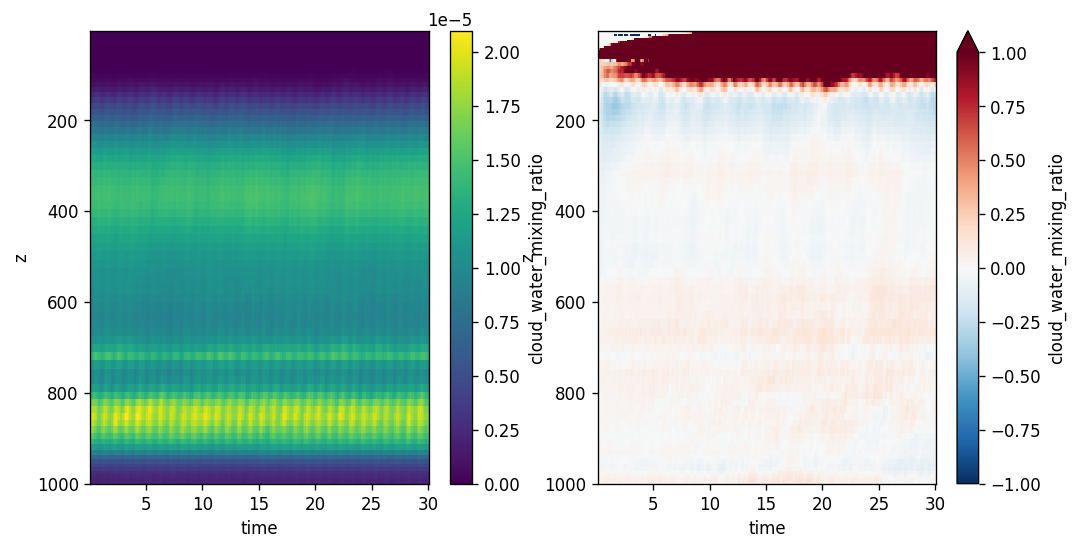

In [20]:
cloud_water, cloud_water_bias = get_bias("cloud_water_mixing_ratio", args, results, pct=True)
fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
cloud_water.plot(y="z", yincrease=False, ax=ax[0])
cloud_water_bias.plot(y="z", yincrease=False, ax=ax[1], vmin=-1, vmax=1, cmap="RdBu_r")
plt.show()

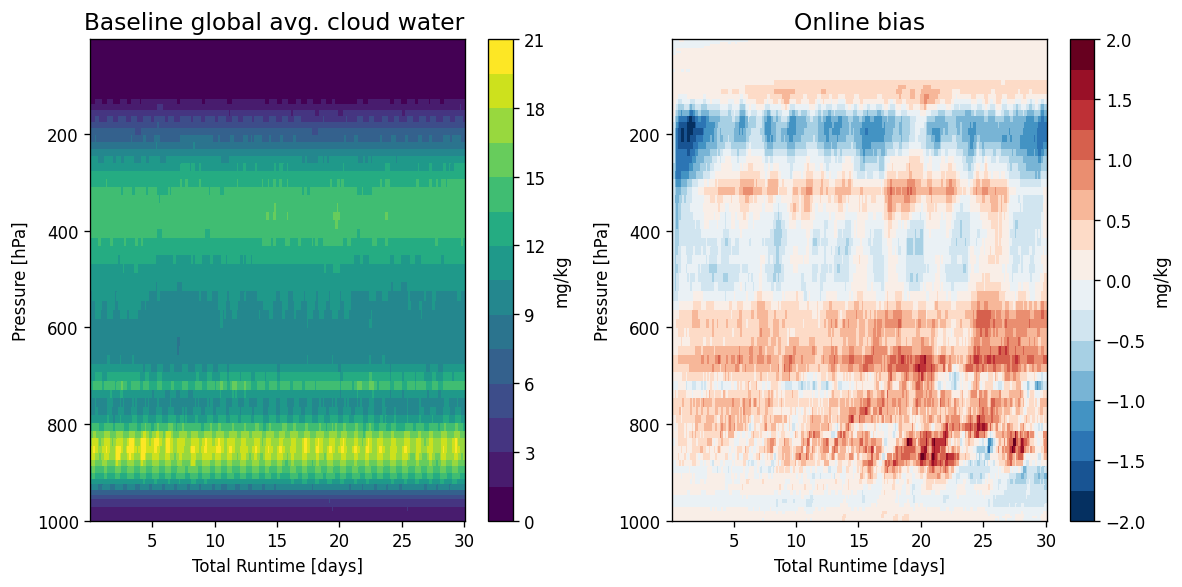

In [21]:
cloud_water, cloud_water_bias = get_bias("cloud_water_mixing_ratio", args, results, pct=False)
fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
(cloud_water * 1e6).plot(y="z", yincrease=False, ax=ax[0], levels=20, cbar_kwargs=dict(label="mg/kg"))
(cloud_water_bias * 1e6).plot(y="z", yincrease=False, ax=ax[1], cmap="RdBu_r", levels=20, cbar_kwargs=dict(label="mg/kg"))
ax[0].set_ylabel("Pressure [hPa]")
ax[1].set_ylabel("Pressure [hPa]")
ax[0].set_xlabel("Total Runtime [days]")
ax[1].set_xlabel("Total Runtime [days]")
ax[0].set_title("Baseline global avg. cloud water ", size=14)
ax[1].set_title("Online bias", size=14)
plt.tight_layout()
plt.show()

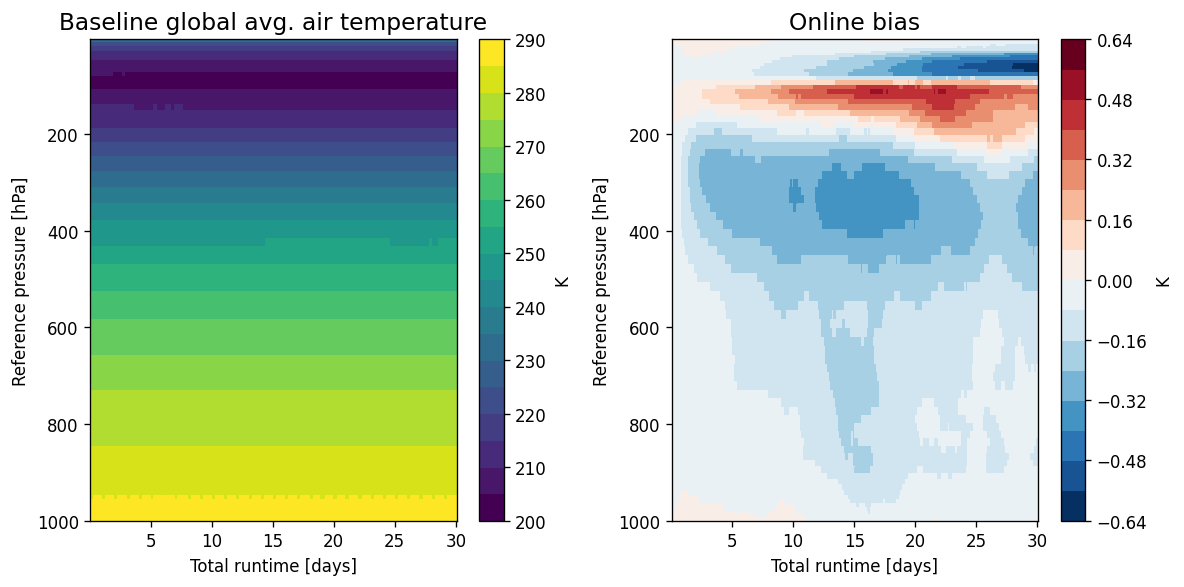

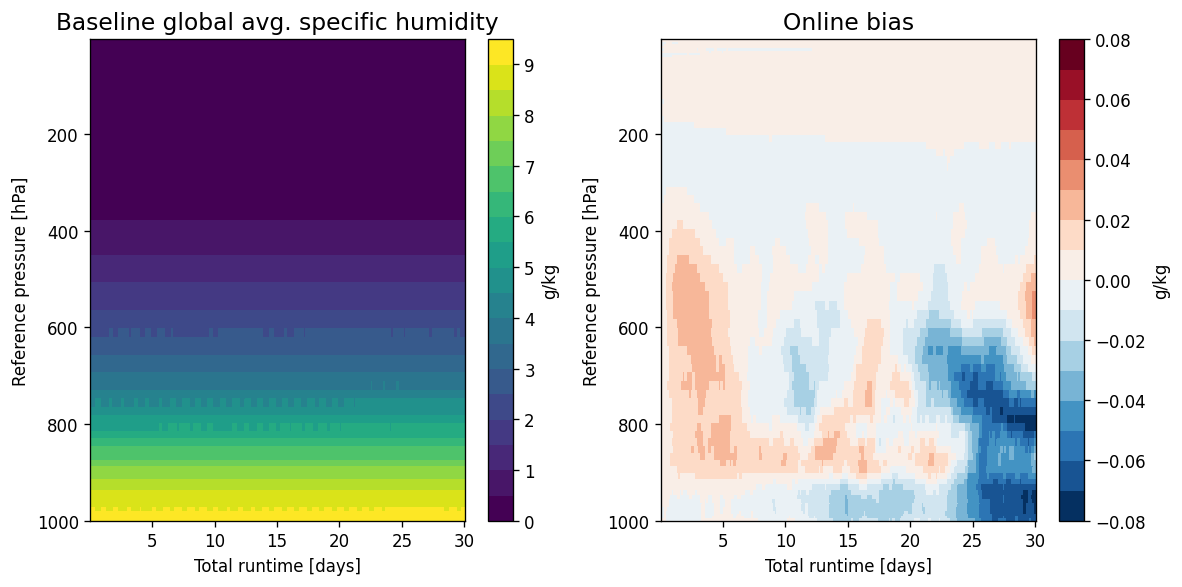

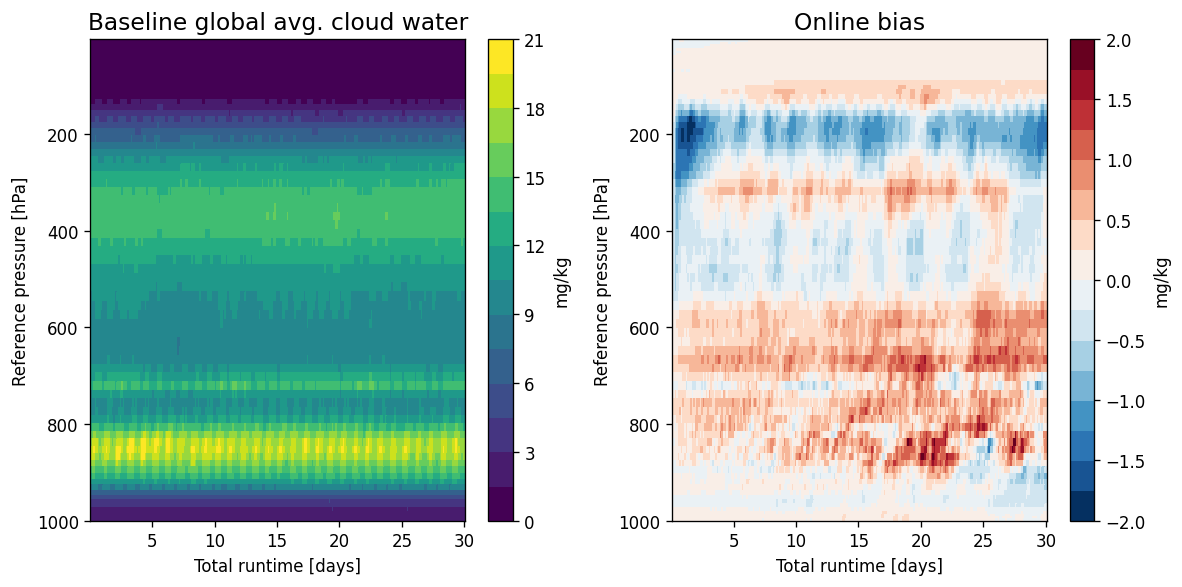

In [22]:
units = {
    "cloud_water_mixing_ratio": "mg/kg",
    "air_temperature": "K",
    "specific_humidity": "g/kg",
}

scale_factors = {
    "cloud_water_mixing_ratio": 1e6,
    "specific_humidity": 1e3,
}

simple_name = {
    "cloud_water_mixing_ratio": "cloud water",
    "air_temperature": "air temperature",
    "specific_humidity": "specific humidity",
}

for f in fields:
    baseline, bias = get_bias(f, args, results, pct=False)
    scale_factor = scale_factors.get(f, 1)
    unit_label = units[f]
    
    fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
    (baseline * scale_factor).plot(y="z", yincrease=False, ax=ax[0], levels=20, cbar_kwargs=dict(label=unit_label))
    (bias * scale_factor).plot(y="z", yincrease=False, ax=ax[1], levels=20, cbar_kwargs=dict(label=unit_label))
    ax[0].set_ylabel("Reference pressure [hPa]")
    ax[1].set_ylabel("Reference pressure [hPa]")
    ax[0].set_xlabel("Total runtime [days]")
    ax[1].set_xlabel("Total runtime [days]")
    ax[0].set_title(f"Baseline global avg. {simple_name[f]}", size=14)
    ax[1].set_title("Online bias", size=14)
    plt.tight_layout()
    plt.show()

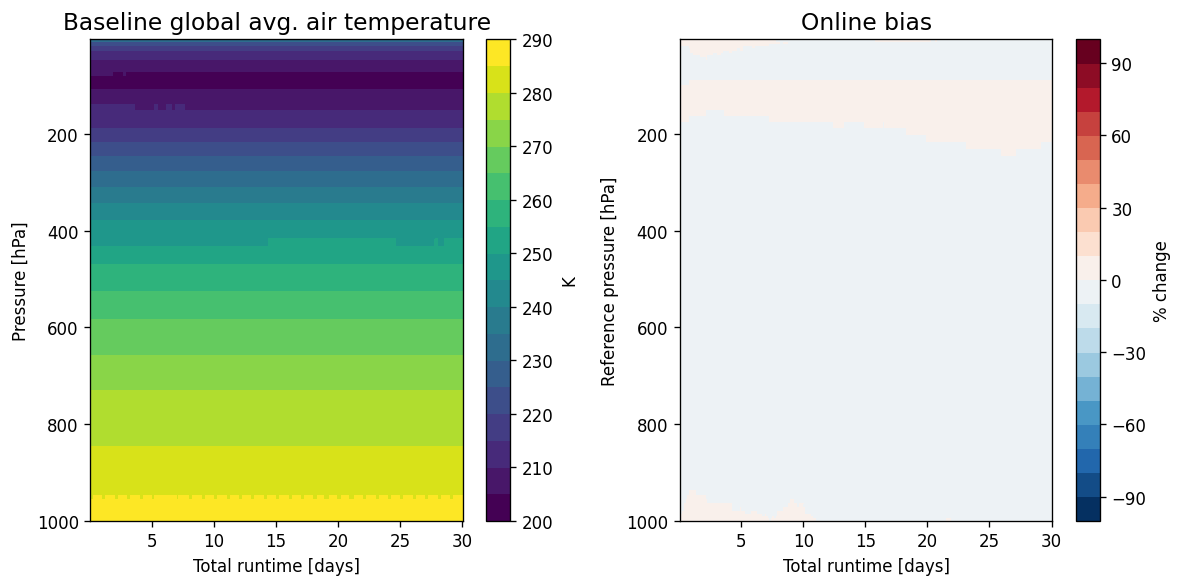

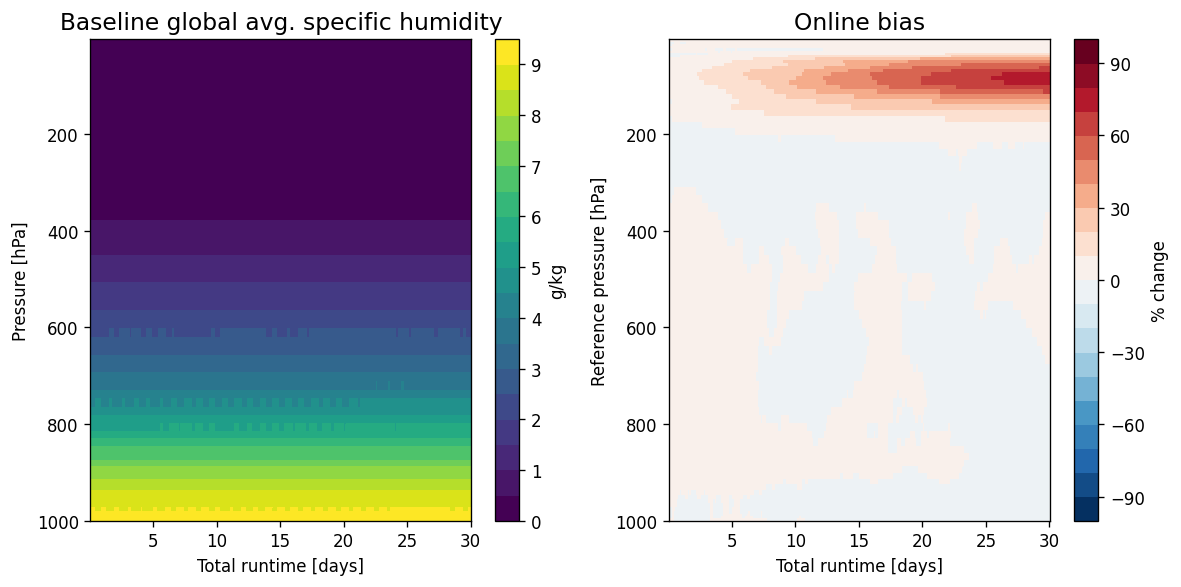

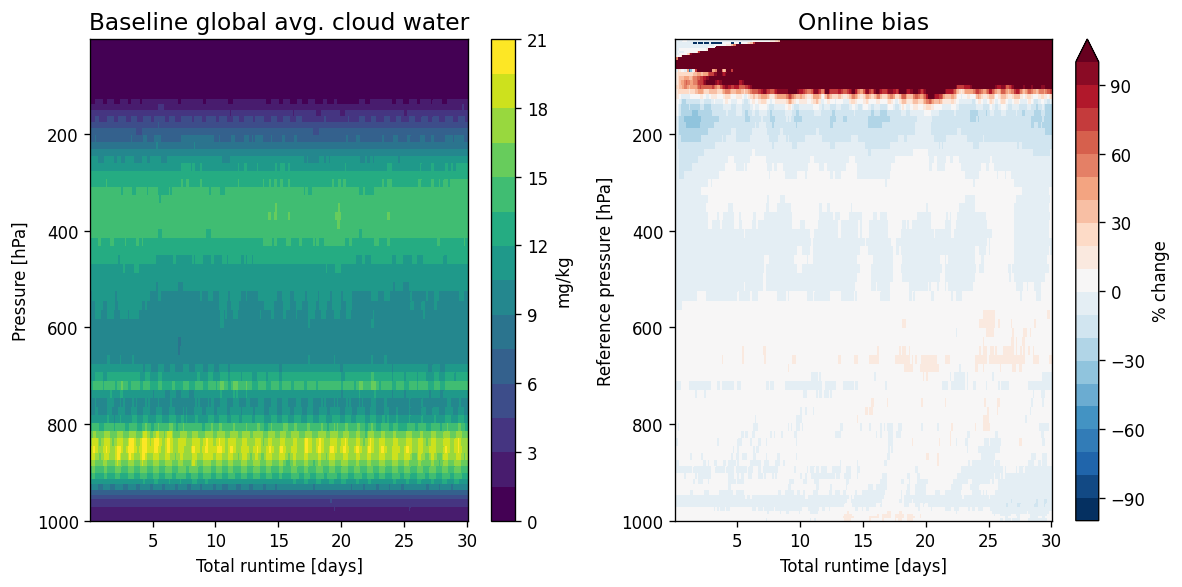

In [23]:
for f in fields:
    baseline, bias = get_bias(f, args, results, pct=True)
    scale_factor = scale_factors.get(f, 1)
    unit_label = units[f]
    
    fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
    (baseline * scale_factor).plot(y="z", yincrease=False, ax=ax[0], levels=20, cbar_kwargs=dict(label=unit_label))
    (bias * 100).plot(y="z", yincrease=False, ax=ax[1], levels=21, vmin=-100, vmax=100, cmap="RdBu_r", cbar_kwargs=dict(label="% change"))
    ax[0].set_ylabel("Pressure [hPa]")
    ax[1].set_ylabel("Reference pressure [hPa]")
    ax[0].set_xlabel("Total runtime [days]")
    ax[1].set_xlabel("Total runtime [days]")
    ax[0].set_title(f"Baseline global avg. {simple_name[f]}", size=14)
    ax[1].set_title("Online bias", size=14)
    plt.tight_layout()
    plt.show()